In [1]:
#### Load library
import scanpy as sc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.image as mpimg
import matplotlib as mpl
from matplotlib.pyplot import rc_context
import os
import ProxseqClasses as PC
import Proxseqnetwork as WPPI
import SpatialproxseqClasses as SPC
#*****
mpl.rcdefaults()
# Set font to be arial
mpl.rc('font', **{'sans-serif':'Arial', 'size':12})
mpl.rcParams['mathtext.rm'] = 'sans' # to have non-italic greek letter, use r'$\mathrm{\alpha}$', does NOT work with f-string
mpl.rcParams['axes.titlesize'] = 12
# Set default tick size
mpl.rcParams['xtick.major.size'] = 5.5
mpl.rcParams['ytick.major.size'] = 5.5
mpl.rcParams['xtick.minor.size'] = 2.5
mpl.rcParams['ytick.minor.size'] = 2.5
# Default legend settings
mpl.rcParams['legend.fancybox'] = False
mpl.rcParams['legend.edgecolor'] = 'k'

#to store text as text, not as path
new_rc_params = {'text.usetex': False,
                 "svg.fonttype": 'none'}
mpl.rcParams.update(new_rc_params)
sc.settings.verbosity = 3


In [2]:
A1_fisher_test = pd.read_csv('A1_fisher_test.csv', index_col=0)
B1_fisher_test = pd.read_csv('B1_fisher_test.csv', index_col=0)
D1_fisher_test = pd.read_csv('D1_fisher_test.csv', index_col=0)

A1_adata_mRNA_cell_clusters = pd.read_csv('A1_adata_mRNA_cell_clusters.csv')
B1_adata_mRNA_cell_clusters = pd.read_csv('B1_adata_mRNA_cell_clusters.csv')
D1_adata_mRNA_cell_clusters = pd.read_csv('D1_adata_mRNA_cell_clusters.csv')


In [3]:
def process_sample(sample_name, fisher_file, cluster_file, threshold=0.15):
    """
    Process a sample to identify significant PLA pairs based on Fisher's test,
    and categorize them into homodimers, bidirectional heterodimers, and unidirectional heterodimers.

    The function filters PLA pairs that exceed the significance threshold
    in at least one of the following clusters:
    'Non-GC follicles', 'Dark zone', 'Light zone'.

    If some of these clusters do not exist in the sample, the filtering
    will be done using the existing clusters only.

    Returns:
    - filtered_fisher_cluster: DataFrame with filtered PLA pairs
    - categorized_df: DataFrame categorizing PLA pairs
    """
    import pandas as pd

    # Load Fisher test and cluster annotation data
    fisher_df = pd.read_csv(fisher_file, index_col=0)
    cluster_df = pd.read_csv(cluster_file)
    cluster_df.set_index("cell_index", inplace=True)

    # Extract cells belonging to this sample
    selected_cells = cluster_df.index.tolist()
    filtered_fisher_df = fisher_df[selected_cells]
    cell_to_cluster = cluster_df['mrna_annotation']

    # Get all clusters present in the sample
    sample_clusters = cell_to_cluster.unique()

    # Compute the fraction of significant p-values per cluster
    clustered_fractions = pd.DataFrame(index=fisher_df.index, columns=sample_clusters)
    for cluster in sample_clusters:
        cells = cell_to_cluster[cell_to_cluster == cluster].index
        if len(cells) > 0:
            clustered_fractions[cluster] = (filtered_fisher_df[cells] < 0.05).mean(axis=1)

    # Filter PLA pairs: at least one valid cluster exceeds the threshold
    valid_clusters = [c for c in ['Non-GC follicles', 'Dark zone', 'Light zone'] if c in clustered_fractions.columns]

    if len(valid_clusters) == 0:
        raise ValueError(f"No valid clusters found in sample {sample_name}. Available clusters: {sample_clusters}")

    filtered_fisher_cluster = clustered_fractions.loc[
        (clustered_fractions[valid_clusters] > threshold).any(axis=1)
    ]

    # Step 2: Categorize PLA pairs
    pla_pairs = list(filtered_fisher_cluster.index)

    homodimers = []
    bidirectional_heterodimers = set()
    unidirectional_heterodimers = []
    seen = set()

    for pair in pla_pairs:
        prot1, prot2 = pair.split(':')
        reversed_pair = f"{prot2}:{prot1}"

        if prot1 == prot2:
            homodimers.append(pair)
        elif reversed_pair in pla_pairs:
            if reversed_pair not in seen:
                bidirectional_heterodimers.add(tuple(sorted([prot1, prot2])))
            seen.add(pair)
        else:
            unidirectional_heterodimers.append(pair)

    bidirectional_heterodimers = [f"{a}:{b}" for a, b in bidirectional_heterodimers]

    # Align lengths for table output
    max_len = max(len(homodimers), len(bidirectional_heterodimers), len(unidirectional_heterodimers))
    def pad_list(lst, length):
        return lst + [''] * (length - len(lst))

    categorized_df = pd.DataFrame({
        "Homodimer": pad_list(homodimers, max_len),
        "Bidirectional_Heterodimer": pad_list(bidirectional_heterodimers, max_len),
        "Unidirectional_Heterodimer": pad_list(unidirectional_heterodimers, max_len),
    })

    return filtered_fisher_cluster, categorized_df


In [4]:
A1_fisher, A1_categorized = process_sample("A1", "A1_fisher_test.csv", "A1_adata_mRNA_cell_clusters.csv")
B1_fisher, B1_categorized = process_sample("B1", "B1_fisher_test.csv", "B1_adata_mRNA_cell_clusters.csv")
D1_fisher, D1_categorized = process_sample("D1", "D1_fisher_test.csv", "D1_adata_mRNA_cell_clusters.csv")


A1_categorized.to_csv("A1_pla_pair_pass_fisher_test_0.15_B_cell_cluster.csv", index=False)
B1_categorized.to_csv("B1_pla_pair_pass_fisher_test_0.15_B_cell_cluster.csv", index=False)
D1_categorized.to_csv("D1_pla_pair_pass_fisher_test_0.15_B_cell_cluster.csv", index=False)


In [5]:
A1_pla_pair_classification = pd.read_csv('A1_pla_pair_pass_fisher_test_0.15_B_cell_cluster.csv')
B1_pla_pair_classification = pd.read_csv('B1_pla_pair_pass_fisher_test_0.15_B_cell_cluster.csv')
D1_pla_pair_classification = pd.read_csv('D1_pla_pair_pass_fisher_test_0.15_B_cell_cluster.csv')


In [6]:
def extract_column_set(df, column):
    """Extract non-empty, standardized (sorted) protein pairs from a column as a set."""
    raw_values = df[column].dropna().unique()
    raw_values = [x for x in raw_values if x != '']

    standardized_set = set()
    for val in raw_values:
        proteins = val.split(":")
        if len(proteins) == 2:
            standardized_set.add(":".join(sorted(proteins)))
        else:
            # Handle malformed cases like missing ":"
            standardized_set.add(val)

    return standardized_set


def get_intersection_long_dataframe(A1_df, B1_df, D1_df, output_file):
    """
    Combine Heterodimer types within each sample, then compute intersections across A1, B1, and D1.
    Output:
      - long-format DataFrame with 'type' and 'protein_pair'
      - A1_heterodimer set
      - B1_heterodimer set
      - D1_heterodimer set
    """
    intersection_list = []

    # Step 1: Get Heterodimer sets per sample (Bidirectional + Unidirectional)
    A1_heterodimer = extract_column_set(A1_df, 'Bidirectional_Heterodimer') | extract_column_set(A1_df, 'Unidirectional_Heterodimer')
    B1_heterodimer = extract_column_set(B1_df, 'Bidirectional_Heterodimer') | extract_column_set(B1_df, 'Unidirectional_Heterodimer')
    D1_heterodimer = extract_column_set(D1_df, 'Bidirectional_Heterodimer') | extract_column_set(D1_df, 'Unidirectional_Heterodimer')

    heterodimer_intersection = sorted(A1_heterodimer & B1_heterodimer & D1_heterodimer)

    for pair in heterodimer_intersection:
        intersection_list.append({'type': 'Heterodimer', 'protein_pair': pair})

    # Step 2: Homodimer intersection
    A1_homodimer = extract_column_set(A1_df, 'Homodimer')
    B1_homodimer = extract_column_set(B1_df, 'Homodimer')
    D1_homodimer = extract_column_set(D1_df, 'Homodimer')

    homodimer_intersection = sorted(A1_homodimer & B1_homodimer & D1_homodimer)

    for pair in homodimer_intersection:
        intersection_list.append({'type': 'Homodimer', 'protein_pair': pair})

    # Step 3: Output as DataFrame
    df_long = pd.DataFrame(intersection_list)
    df_long.to_csv(output_file, index=False)
    print(f"Intersection saved to {output_file}")

    return (
    df_long,
    A1_heterodimer, B1_heterodimer, D1_heterodimer,
    A1_homodimer,   B1_homodimer,   D1_homodimer,
    set(homodimer_intersection)
)

In [7]:
(intersection_df,
 A1_heterodimer, B1_heterodimer, D1_heterodimer,
 A1_homodimer,   B1_homodimer,   D1_homodimer,
 homo_intersection) = get_intersection_long_dataframe( 
    A1_pla_pair_classification, B1_pla_pair_classification, D1_pla_pair_classification, "A1_B1_D1_pla_pair_pass_fisher_test_0.15_B_cell_cluster.csv")


Intersection saved to A1_B1_D1_pla_pair_pass_fisher_test_0.15_B_cell_cluster.csv


In [8]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

def plot_equal_venn_from_sets(A, B, D, labels=('Sample A1', 'Sample B1', 'Sample D1'),
                              colors=('#2F5597', '#9C0006', '#548235'),
                             save_path=None, dpi=300, title="Protein Pair Intersection"):
    """
    Plot a Venn diagram with three equal-sized circles using set data.
    Automatically computes the numbers for each region.
    """
    # Calculate counts for each region
    counts = {
        '100': len(A - B - D),
        '010': len(B - A - D),
        '001': len(D - A - B),
        '110': len((A & B) - D),
        '101': len((A & D) - B),
        '011': len((B & D) - A),
        '111': len(A & B & D)
    }

    fig, ax = plt.subplots(figsize=(4, 4))
    circle_positions = [(0, 0), (1, 0), (0.5, 0.8)]
    radius = 1.0

    # Draw the circles
    for pos, color in zip(circle_positions, colors):
        ax.add_patch(Circle(pos, radius, alpha=0.5, color=color))

    # Place the counts
    ax.text(-0.5, 0, counts['100'], ha='center', va='center', fontsize=12)
    ax.text(1.5, 0, counts['010'], ha='center', va='center', fontsize=12)
    ax.text(0.5, 1.6, counts['001'], ha='center', va='center', fontsize=12)
    ax.text(0.25, 0, counts['110'], ha='center', va='center', fontsize=12)
    ax.text(0, 0.8, counts['101'], ha='center', va='center', fontsize=12)
    ax.text(1, 0.8, counts['011'], ha='center', va='center', fontsize=12)
    ax.text(0.5, 0.4, counts['111'], ha='center', va='center', fontsize=12, fontweight='bold')

    # Labels
    ax.text(-0.7, -1.1, labels[0], fontsize=12, color=colors[0])
    ax.text(1.7, -1.1, labels[1], fontsize=12, color=colors[1])
    ax.text(0.5, 2.0, labels[2], fontsize=12, color=colors[2])

    ax.set_xlim(-1.5, 2.5)
    ax.set_ylim(-1.5, 2.5)
    ax.set_aspect('equal')
    ax.axis('off')
    plt.title(title)
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
        print(f"Venn diagram saved to {save_path}")
    plt.show()
     # Save the figure if save_path is specified
# Example usage:
# plot_equal_venn_from_sets(A1_set, B1_set, D1_set)


Venn diagram saved to Figures/Fig-4d.svg


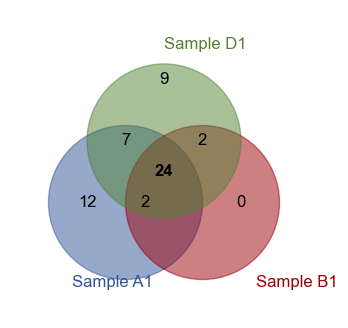

In [9]:
plot_equal_venn_from_sets(A1_heterodimer, B1_heterodimer, D1_heterodimer,
                          labels=('Sample A1', 'Sample B1', 'Sample D1'), save_path = 'Figures/Fig-4d.svg', title = None)


Venn diagram saved to Figures/Extended-Fig-11d.svg


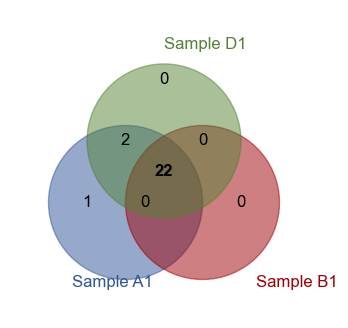

In [10]:
plot_equal_venn_from_sets(
    A1_homodimer,
    B1_homodimer,
    D1_homodimer,
    labels=('Sample A1', 'Sample B1', 'Sample D1'),save_path = 'Figures/Extended-Fig-11d.svg',
    title=None
)
